# Convex Optimization: Nonlinear Optimization

**Prerequisites**

- Convex Optimization: Theory

**Outcomes**

- Understand various algorithms for solving nonlinear optimization problems:
    - Bisection for univariate problems
    - Gradient Descent
    - Newton's Method

## Univariate Optimization: $\mathbb{R} \rightarrow \mathbb{R}$

We will begin with the task of minimizing a function $f: \mathbb{R} \rightarrow \mathbb{R}$

We'll also suppose that the only constraint on the optimization problem a bound constraint on $x$

The optimization problem is

\begin{align*}
\min_x \quad & f(x) \\
s.t. \quad & a \le x \le b
\end{align*}


As a test example, we will solve the following problem:

\begin{align*}
\min_x \quad & (x - 3)^2 + 2 \\
s.t. \quad & 0 \le x \le 10
\end{align*}

In [1]:
def func1(x):
    return (x - 3) ** 2 + 2

### Bisection

The first algorithm we will learn that can solve this problem is called the bisection algorithm

The bisection algorithm works by iteratively splitting the size of the interval containing the optimal $x$ in half, always choosing the half of the interval where the function value is smallest

Let $a_i$ and $b_i$ represent upper and lower bound of interval on iteration $i$ (note that $a_0 = a$ and $b_0 = b$ from optimization problem)

At each step

- compute $m_i = (a_i + b_i) / 2$
- Compute $fa = f(a_i)$, $fb = f(b_i)$, and $fm = f(m_i)$
- Find new interval:
    - If $fa < fb$ then $a_{i+1} = a_i$ and $b_{i+1} = m_i$
    - Else ($fa \ge fb$) set $a_{i+1} = m_i$ and $b_{i+1} = b_i$
- Stop iterating when $a_i$ and $m_i$ are sufficiently close

Let's implement the algorithm below!

In [2]:
def bisect_opt(f, a, b, tol=1e-8):
    """
    Find the minimum of the scalar function $f$ on the interval
    from $[a, b]$ to a given tolerance

    Returns
    -------
    out: Dict
        A dictionary containing keys `x` for the optimizing `x`,
        `val` for the optimal function value and `history` containing
        a history of iteration progress
    """
    # set up i and hist for tracking algorithm progress
    i = 0
    hist = []

    # compute midpoint and evaluate function at a, b, m
    m = (a + b) / 2
    fa = f(a)
    fb = f(b)
    fm = f(m)

    while abs(a - m) > tol:
        hist.append(dict(
            i=i, a=a, b=b, m=m, fa=fa, fb=fb, fm=fm
        ))
        # choose (a, b) to be smallest two function values
        # from (a, m, b)
        if fa < fb:
            b = m
            fb = fm
        else:
            a = m
            fa = fm

        # compute new midpoint and increment iteration counter
        m = (a + b) / 2
        fm = f(m)
        i += 1

    return dict(x=m, val=fm, history=hist)

We can now test our function out on the sample problem (note that we know the optimal answer is x = 3)



In [3]:
out = bisect_opt(func1, 0, 10, tol=1e-2)
out["x"], len(out["history"])

(2.998046875, 9)

Below we will plot the evolution of the algorithm

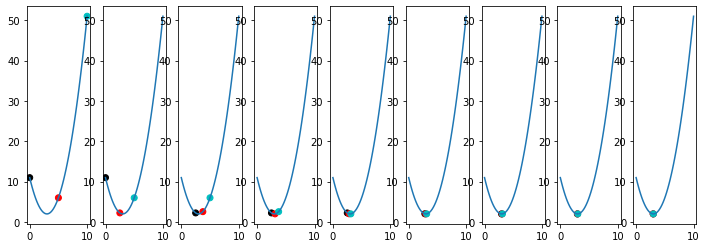

In [4]:
import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(0, 10, 50)
xstar = 3
fx = func1(x)

fig, axs = plt.subplots(1, len(out["history"]), figsize=(12, 4))

for step, ax in zip(out["history"], axs):
    ax.plot(x, fx)
    ax.scatter(
        [step["a"], step["m"], step["b"]],
        [step["fa"], step["fm"], step["fb"]],
        label="step {}".format(step["i"]),
        c=["k", "r", "c"],
    )

In [5]:
import pandas as pd
pd.DataFrame(out["history"])

,i,a,b,m,fa,fb,fm
0,0,0.00000,10.000000,5.000000,11.000000,51.000000,6.000000
1,1,0.00000,5.000000,2.500000,11.000000,6.000000,2.250000
2,2,2.50000,5.000000,3.750000,2.250000,6.000000,2.562500
3,3,2.50000,3.750000,3.125000,2.250000,2.562500,2.015625
4,4,2.50000,3.125000,2.812500,2.250000,2.015625,2.035156
5,5,2.81250,3.125000,2.968750,2.035156,2.015625,2.000977
6,6,2.96875,3.125000,3.046875,2.000977,2.015625,2.002197
7,7,2.96875,3.046875,3.007812,2.000977,2.002197,2.000061
8,8,2.96875,3.007812,2.988281,2.000977,2.000061,2.000137


## Optimization via derivatives

Above we solved the problem of minimizing $f(x)$ by evaluating $f$ at many locations and making intelligent decisions about where to evaluate next

We know from calculus that we can optimize $f(x)$ by finding the point $x'$ where $\frac{df}{dx} = 0$

Optimization and derivatives are very closely linked

### Example

Recall our example function $f(x) = (x - 3)^2 + 2$

For this function we can readily compute the derivative analytically $\frac{df}{dx} = 2 (x - 3)$

Setting the derivative equal to zero and solving reveals that the optimal $x = 3$

### Derivatives With Code

For many problems the derivative may either be difficult or impossible to compute analytically

In these cases we can rely on the computer to compute or approximate derivatives for us

### Finite Difference Methods

Historically, the most common way to approximate derivatives numerically was to use some form of finite differences

These methods are instructive and very helpful when considering applications like solving differential equations

A finite difference (FD) method approximates a derivative numerically

As an approximation, there will be some error associated with FD approximations

If we care only about being able to evaluate the derivative of an arbitrary function at an arbitrary point there is a better way: automatic differentiation

We will study automatic differentiation in this lecture

There will be some exercises with finite methods on the homework

### Automatic differentiation

Automatic differentiation is a family of computer science techniques that allow a computer to evaluate *exact* derivatives *numerically*

The details behind how this works are beyond the scope of this lecture

In our purposes here we will rely on an implementation of automatic differentiation in the `jax` python library

Let's dive in to how `jax` works using our example function from above

In [6]:
# uncomment if you don't have jax
#%pip install --user jax jaxlib

In [7]:
from jax import jit, grad

def grad_func1(x):
    "Analytical derivative for comparison with jax' output"
    return 2 * (x - 3)

jax_grad_func1 = grad(func1)

In [8]:
jax_grad_func1(10.0), grad_func1(10.0)

(DeviceArray(14., dtype=float32), 14.0)

In [9]:
np.array([jax_grad_func1(i) for i in x]) - grad_func1(x)

array([ 0.00000000e+00, -1.94627411e-07,  8.75823352e-08, -1.07045077e-07,
        1.75164670e-07, -1.94627412e-08,  2.43284264e-08,  6.81195940e-08,
        1.11910762e-07, -8.27166500e-08, -3.89254824e-08, -2.33552894e-07,
        4.86568528e-08, -1.45970558e-07,  1.36239188e-07, -5.83882240e-08,
        2.23821523e-07,  2.91941120e-08, -1.65433300e-07,  1.16776446e-07,
       -7.78509648e-08, -2.72478376e-07, -4.67105789e-07,  2.91941117e-07,
        9.73137055e-08, -9.73137055e-08, -2.91941117e-07,  4.67105787e-07,
        2.72478376e-07,  7.78509648e-08, -1.16776448e-07, -3.11403859e-07,
        4.47643046e-07,  2.53015635e-07,  5.83882240e-08, -1.36239189e-07,
       -3.30866600e-07,  4.28180305e-07,  2.33552893e-07,  3.89254815e-08,
       -1.55701930e-07, -3.50329341e-07, -5.44956752e-07, -7.39584163e-07,
       -9.34211577e-07,  7.78509644e-07,  5.83882233e-07,  3.89254822e-07,
        1.94627411e-07,  0.00000000e+00])

Notice we evaluated `grad_func1` on the entire array `x` at once

On the other hand, we evaluated `jax_grad_func1` in a loop comprehension

Why? *broadcasting*

Numpy applies broadcasting over its arguments -- in this case that means it evaluated our derivative at all elements of `x`

The functions returned by `jax.grad` do not

#### Vectorization via `jax.vmap`

Vectorization is a relative of numpy's broadcasting that applies a function for all elements in a container

`jax` has a function `jax.vmap` that can conusme a function and return a vectorized version

This will allow us to compute the derivative at more than one point at a time

In [11]:
from jax import vmap
vec_jax_grad_func1 = vmap(jax_grad_func1)
vec_jax_grad_func1(x)

DeviceArray([-6.        , -5.591837  , -5.1836734 , -4.7755103 ,
             -4.367347  , -3.9591837 , -3.5510204 , -3.142857  ,
             -2.7346938 , -2.3265307 , -1.9183674 , -1.5102043 ,
             -1.1020408 , -0.6938777 , -0.28571415,  0.12244892,
              0.53061247,  0.93877554,  1.3469386 ,  1.7551022 ,
              2.1632652 ,  2.5714283 ,  2.9795914 ,  3.3877554 ,
              3.7959185 ,  4.2040815 ,  4.6122446 ,  5.0204086 ,
              5.4285717 ,  5.836735  ,  6.244898  ,  6.653061  ,
              7.061225  ,  7.469388  ,  7.877551  ,  8.285714  ,
              8.693877  ,  9.102041  ,  9.510204  ,  9.918367  ,
             10.32653   , 10.734694  , 11.142857  , 11.55102   ,
             11.959183  , 12.367348  , 12.775511  , 13.183674  ,
             13.591837  , 14.        ], dtype=float32)

### Bisecting $\frac{df}{dx} = 0$

Now that we can take derivatives of Python functions, we can apply the optimization technique of finding $x'$ such that $\frac{df}{dx} |_{x=x'} = 0$

The core strategy of the bisection algorithm applies to finding zeros ("root-finding" or "solving")

Let `df` be a Python function that represents $\frac{df}{dx}$

Given `df` and bounds `a` and `b`, an optimal value for the function `f` can be found as follows

- Initialization
    - confirm that exactly one of $df(a)$, $df(b)$ is negative
    - Set $a_0 = a$ and $b_0 = b$
- Iteration
    - compute $m_i = (a_i + b_i) / 2$
    - Compute $dfa = df(a_i)$, $dfb = df(b_i)$, and $dfm = df(m_i)$
    - Find new interval:
        - If $dfa \cdot dfm > 0$ then $a_{i+1} = m_i$ and $b_{i+1} = b_i$
        - Else set $a_{i+1} = a_i$ and $b_{i+1} = m_i$
    - Stop iterating when $a_i$ and $m_i$ are sufficiently close

**Exercise** Implement the `bisect_zero` function below

Verify that it works when you pass in `jax_grad_func1` (the correct answer should be `3` as when we call `bisect_opt` above)

In [ ]:
def bisect_zero(df, a, b, tol=1e-8):
    """
    Find the zero of the scalar function $df$ on the interval
    from $[a, b]$ to a given tolerance

    It must be true that `df(a) * df(b) < 0` so that the interval
    [a,b] is said to bracket a zero of `df`.

    Returns
    -------
    out: Dict
        A dictionary containing keys `x` for the optimizing `x`,
        `val` for the optimal function value and `history` containing
        a history of iteration progress
    """
    pass

### Comment: Solving vs Optimizing

As shown above, the computations required to find the roots or zeros of a function (also called "solve" the function) are similar to the computations needed to optimize the function

In particular, for any convex function $f$, solving $\min_x f(x)$ is equivalent to solving $\frac{df}{dx} = 0$

Many of the algorithms used to optimize and solve functions are very similar

In the remainder of this lecture we will focus on optimizing

## Multivariate $x$

Now we turn to the case where the domain of $f$ is $n$ dimensional

Let $f: \mathbb{R}^n \rightarrow \mathbb{R}$

Define the gradient of $f$ ($\nabla f$) as $$\nabla f(x) \equiv \begin{bmatrix} \frac{\partial f}{\partial x_1} \\ \frac{\partial f}{\partial x_2} \\ \vdots \\  \frac{\partial f}{\partial x_n}\end{bmatrix}$$


There are many algorithms for solving the multivariate optimization problem

Many of them iterate on value of $x$ and follow an update rule of the form $$x_{i+1} = x_i + \alpha_i p_i$$

where $\alpha_k$ is known as a step size and $p_k$ is the search direction

### Gradient Descent

One algorithm we will study is called *gradient descent*

The gradient $\nabla f(x) |_{x=x_1}$ points in the direction of the greatest *increase* in $f$, at $x_1$

It follows that $-\nabla f(x) |_{x=x_1}$ points in the direction of steepest *decrease* in $f$ at $x_1$

If we continue to follow the direction of steepest decrease, we will eventually end up at a point $x^*$ where $\nabla f(x)|_{x=x^*} = 0$, which means that $x^*$ is optimal value of $f$!


#### Gradient Descent Algorithm

The intuition above can be formalized into an algorithm as follows

- Initialization: Choose an initial point $x_0$, a step size $\alpha$, and a stopping tolerance $\epsilon$
- Iteration: for $i = 0, \dots$
    - Set $x_{i+1} = x_i - \alpha \nabla f(x) |_{x_i}$
    - If $\max(\text{abs}(x_{i+1} - x_i)) < \epsilon$ return $x_{i+1}$ as $x^*$

In theory this algorithm *should* work, in practice is often doesn't with a constant step size $\alpha$

A modification to this algorithm would be to compute an optimal step size given the current $x$

That is, on iteration $i$ solve the following univariate optimization problem for $\alpha_i$:

$$\min_{\alpha_i} f(x_i - \alpha_i \nabla f(x) | _{x=x_i})$$

We'll implement this algorithm below

The sub-problem for finding $\alpha_i$ is known as line search

In [12]:
def gradient_descent(f, x0, tol=1e-5, maxiter=10000):
    """
    Find a local optimum of the function $f$ near x0 using the
    gradient descent algorithm
    """
    hist = []
    df = grad(f)
    i = 0
    x = x0
    while i < maxiter:
        if any(np.isnan(x)): 
            raise ValueError("Got some nans on iteration {}".format(i))
        i += 1
        dfx = df(x)
        alpha = bisect_opt(lambda a: f(x - a * dfx), 1e-5, 10)["x"]
        xp = x - alpha * dfx
        diff = max(abs(x - xp))
        hist.append(dict(i=i, x=x, dfx=dfx, diff=diff, xp=xp, alpha=alpha))

        x = xp
        if diff < tol:
            break

    return dict(x=x, val=f(x), dfx=dfx, history=hist)

#### The Rosenbrock function

A common function used to test optimization algorithms is called the Rozenbrock function

The function can be defined over a domain of an arbitrary number of dimensions, which we'll call $N$

$$f(x) = \sum_{i=1}^{N-1} 100 (x_{i+1} - x_i^2) + (1 - x_i)^2$$

Let's see what this looks like for $N = 2$

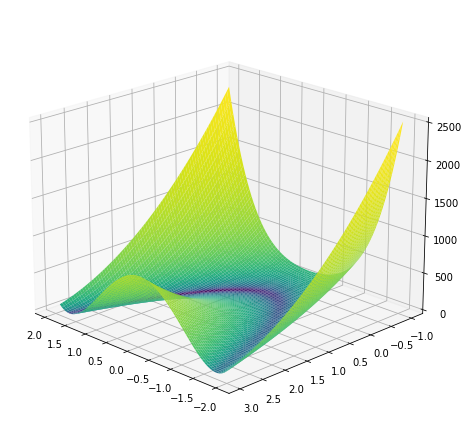

In [13]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
fig = plt.figure(figsize=(10, 6))
ax = Axes3D(fig, azim = 135, elev=20)
X, Y = np.mgrid[-2:2:0.05, -1:3:0.05]
Z = (1 - X)**2 + 100*(Y - X**2)**2
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, norm=LogNorm(), cmap="viridis")

Let's use our `gradient_descent` function to optimize the rosenbrock function in 2d

Note that the minimum is `[1, 1]` with a value of 0


In [14]:
def rosen(x): 
    return sum(100.0 * (x[1:] - x[:-1]**2.0)**2.0 + (1 - x[:-1])**2.0)

In [15]:
import jax.numpy as jnp
%time rosen_res_gd = gradient_descent(jit(rosen), np.ones(2)*0.5)

msg = "Found optimal value of {} at {} in {} iterations"
print(msg.format(rosen_res_gd["val"], rosen_res_gd["x"], len(rosen_res_gd["history"])))

CPU times: user 47.5 s, sys: 11.1 s, total: 58.6 s
Wall time: 41.2 s
Found optimal value of 2.2985574332778924e-08 at [0.9998485  0.99969643] in 2101 iterations


### Newton's Method

The method gradient descent method  worked for our problem above, but was rather inefficient

It took over 2000 iterations, each of which had an optimization problem to solve

This is not uncommon for gradient descent

In fact, gradient descent can often lead to oscillating or explosive behavior

In either case, we can say that the gradient descent algorithm produced steps that were not improving

An alternative to gradient descent that does not have these same symptoms is Newton's method

Newton's method is similar to gradient descent, but chooses a step size based on the second derivative of the objective function

The optimal step size is found using a second order Taylor series expansion of $f$ around the current $x$ at each iteration (say $x_i$)

This expansion has the following form:

$$f(x_i + \Delta) \approx f(x_i) + \Delta^T \nabla f(x) |_{x=x_i} + \frac{1}{2}\Delta^T H(f)(x)|_{x=x_i} \Delta,$$

where $H(f)(x) \equiv \begin{bmatrix}
  \dfrac{\partial^2 f}{\partial x_1^2} & \dfrac{\partial^2 f}{\partial x_1\,\partial x_2} & \cdots & \dfrac{\partial^2 f}{\partial x_1\,\partial x_n} \\[2.2ex]
  \dfrac{\partial^2 f}{\partial x_2\,\partial x_1} & \dfrac{\partial^2 f}{\partial x_2^2} & \cdots & \dfrac{\partial^2 f}{\partial x_2\,\partial x_n} \\[2.2ex]
  \vdots & \vdots & \ddots & \vdots \\[2.2ex]
  \dfrac{\partial^2 f}{\partial x_n\,\partial x_1} & \dfrac{\partial^2 f}{\partial x_n\,\partial x_2} & \cdots & \dfrac{\partial^2 f}{\partial x_n^2}
\end{bmatrix}$ is the hessian matrix

We can optimize the second order TS expansion for $\Delta$ by taking a derivative, setting equal to zero, and solving for $\Delta$ (note, I use a shorthand for "evaluated at $x_i$")

\begin{align*}
 0 &= \frac{d}{d \Delta} \left(f(x_i) + \Delta^T \nabla f(x_i)+ \frac{1}{2}\Delta^T H(f)(x_i) \Delta \right) \\
 0 &= \nabla f(x) +  H(f)(x) \Delta \\
 \Delta &= -\left[H(f)(x_i)\right]^{-1} \nabla f(x_i)
\end{align*}

With this optimal $\Delta$ in mind, the updating rule for $x$ becomes: $$x_{i+1} = x_i - \alpha \left[H(f)(x_i)\right]^{-1} \nabla f(x_i),$$

where we have added a step size $\alpha$.

We can use `jax` to construct a Hessian matrix for us as follows (see the [documentation](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html#Taking-derivatives-with-grad) for more detail):

In [17]:
from jax import jacfwd, jacrev
def make_hessian(f):
    return jit(jacfwd(jacrev(f)))

Now we are ready to implement Newton's method:

In [18]:
def newtons_method(f, x0, alpha=0.1, tol=1e-5, maxiter=1000):
    hist = []
    df = grad(f)
    Hf = make_hessian(f)
    i = 0
    x = x0
    while i < maxiter:
        if any(np.isnan(x)): 
            raise ValueError("Got some nans on iteration {}".format(i))
        i += 1
        dfx = df(x)
        Hfx = Hf(x)
        Delta = np.linalg.lstsq(Hfx, dfx, rcond=None)[0]
        xp = x - alpha * Delta
        diff = max(abs(x - xp))
        hist.append(dict(i=i, x=x, dfx=dfx, diff=diff, xp=xp, alpha=alpha, Hfx=Hfx, Delta=Delta))

        x = xp
        if diff < tol:
            break

    return dict(x=x, val=f(x), dfx=dfx, history=hist)

In [20]:
%time rosen_res_newton = newtons_method(rosen, np.ones(2)*0.5)
print(msg.format(rosen_res_newton["val"], rosen_res_newton["x"], len(rosen_res_newton["history"])))

CPU times: user 2.72 s, sys: 416 ms, total: 3.14 s
Wall time: 2.19 s
Found optimal value of 1.7569274121903318e-09 at [0.99995887 0.99991694] in 163 iterations


Excellent! We were able to solve the rosenbrock function in far fewer iterations (~160 instead of ~2100) and far less time

This method could be further improved by choosing $\alpha$ each iteration via line search...

**Exercise**

Implement a modified version of Newton's method that incorporates line search

In [ ]:
def newtons_method_linesearch(f, x0, tol=1e-5, maxiter=1000):
    """
    Find a local optimium of `f` near `x0` using Newton's method with
    a line search for step size
    
    Returns
    -------
    out: Dict
        A dictionary containing keys :
        
        - `x` for the optimizing `x`
        - `val` for the optimal function value  
        - `history` containing a history of iteration progress
        - `dfx` containing final gradient of f
        - `Hfx` containing final Hessian matrix of f
    """
    pass